In [62]:
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [63]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

In [74]:
def plot_data(X, Y, a, N2, func, title=None):
    plt.figure(figsize=(12, 4))

    plt.plot(X, Y, 'xk', alpha=0.3)
    #     plt.fill_between(X[:N2, 0], -1.8, 1.8, color='c', alpha=0.2, lw=1.5)
    plt.fill_between(X[a==0], -1.8, 1.8, color='m', alpha=0.2, lw=1.5, label='Mode 1 (low noise)')
    plt.fill_between(X[-N2:, 0], -1.8, 1.8, color='c', alpha=0.2, lw=1.5, label='Mode 2 (high noise)')
#     Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
    Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
    Yt = func(Xt)
    plt.plot(Xt, Yt, c='k')#, label="Underlying function"
    plt.xlabel("$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$", fontsize=20)
    plt.ylabel("$\mathbf{s}_t$", fontsize=20)
    plt.tick_params(labelsize=20)
    plt.ylim(-2.1, 2.1)
    plt.legend(loc='lower right', fontsize=15)
    plt.title(title)
    plt.show()

def gen_data(N=600, frac=0.4, low_noise_var=0.005, high_noise_var=0.3, plot_flag=False):
    """
    N - number of training observations
    a - fraction of observations in mode 2 (high noise mode)
    """
    N2 = int(frac*N/2) # number of observations in mode 2 (high noise)
    # generate input observations X
#     X = rnd.randn(N, 1) * 2 - 1 # X values
    X = rnd.rand(N, 1) * 2 - 1 # X values
#     X = np.linspace(-1.0, 1.0, N)[:, None]

    # generate target observations Y
    Y = np.zeros([N, 1])
    Y = func(X)
    Y[(X>-0.6) & (X<0.6)] += low_noise_var * rnd.randn((Y[(X>-0.6) & (X<0.6)]).shape[0]) #+ 3
    Y[X<-0.6] += high_noise_var  * rnd.randn((Y[X<-0.6]).shape[0]) # add noise to subset of target observations Y
    Y[X>0.6] += high_noise_var  * rnd.randn((Y[X>0.6]).shape[0]) # add noise to subset of target observations Y
#     Y[N2:-N2] += low_noise_var * rnd.randn(N-2*N2,1)
#     Y[-N2:] += high_noise_var  * rnd.randn(N2,1) # add noise to subset of target observations Y
#     Y[:N2] += high_noise_var* rnd.randn(N2,1) # add noise to subset of target observations Y

    # Bernoulli indicator variable, 0 = low noise, 1 = high noise
#     a = np.zeros([N, 1])
#     a[-N2:] = 1
#     a[:N2] = 1
    XX = np.sort(X, axis=0)
    a = np.zeros([N, 1])
    a[XX<-0.6] = 1
    a[XX>0.6] = 1

    if plot_flag == True:
        plot_data(X, Y, a, N2, func)

    return X, Y, a

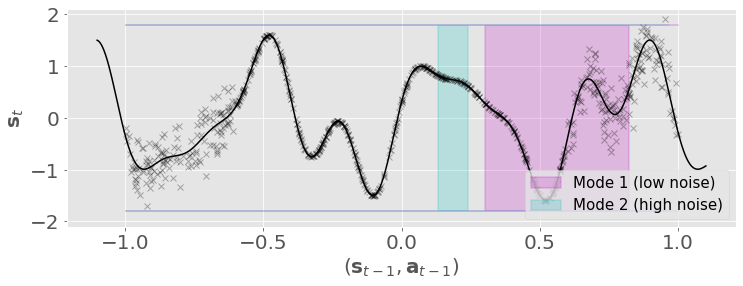

In [75]:
N = 800 # number of training observations
frac = 0.5
fracN = int(frac*N)
X, Y, _ = gen_data(N, frac, plot_flag=True)

In [73]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []

    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

In [33]:
from gpflow.training import monitor as mon
def run_adam(model, maxiter=450):
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=maxiter)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

def plot_loss(logger):
    plt.plot(-np.array(logger.logf))
    plt.xlabel('iteration (x10)')
    plt.ylabel('ELBO');

In [54]:
def plot_model(m, m1=False, m2=False, a=False, h=False, y=False, save_name=False):
    fig = plt.figure(figsize=(12, 4))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations

    plt.plot(X, Y, 'x', color='k', label='Observations', alpha=0.2)
    if m1 or m2 or a or h:
    #     plt.plot(m.feature_f_low.Z.value, np.zeros(m.feature_f_low.Z.value.shape), 'k|', mew=2, label='Inducing locations mode 1')
        plt.plot(m.feature_f_low.Z.value, np.zeros(m.feature_f_low.Z.value.shape), 'k|', mew=2)
        plt.plot(m.feature_f_high.Z.value, np.zeros(m.feature_f_high.Z.value.shape), 'b|', mew=2)
    #     plt.plot(m.feature_f_high.Z.value, np.zeros(m.feature_f_high.Z.value.shape), 'b|', mew=2, label='Inducing locations mode 2')
    #     plt.plot(m.feature_f_low.Z.value, np.zeros(m.feature_f_low.Z.value.shape), 'k|', mew=2, label='Inducing locations mode 1')

    if h is True:
        a_mu, a_var = m.predict_h(pX) # Predict alpha values at test locations
        plt.plot(pX, a_mu, color='olive', lw=1.5)
        plt.fill_between(pX[:, 0], (a_mu-2*a_var**0.5)[:, 0], (a_mu+2*a_var**0.5)[:, 0], color='olive', alpha=0.4, lw=1.5, label='Separation manifold GP')

    if a is True:
        a_mu, a_var = m.predict_a(pX) # Predict alpha values at test locations
        plt.plot(pX, a_mu, color='olive', lw=1.5)
        plt.fill_between(pX[:, 0], (a_mu-2*a_var**0.5)[:, 0], (a_mu+2*a_var**0.5)[:, 0], color='blue', alpha=0.4, lw=1.5, label='$\\alpha$')

    if m1 is True:
        pY_low, pYv_low = m.predict_f_high(pX)
#         pY_low, pYv_low = m.predict_f_low(pX)
        line, = plt.plot(pX, pY_low, color='m', alpha=0.6, lw=1.5)
        plt.fill_between(pX[:, 0], (pY_low-2*pYv_low**0.5)[:, 0], (pY_low+2*pYv_low**0.5)[:, 0], color='m', alpha=0.2, lw=1.5, label='Mode 1 - low noise')

    if m2 is True:
        pY_high, pYv_high = m.predict_f_low(pX)
#         pY_high, pYv_high = m.predict_f_high(pX)
        line, = plt.plot(pX, pY_high, color='c', alpha=0.6, lw=1.5)
        plt.fill_between(pX[:, 0], (pY_high-2*pYv_high**0.5)[:, 0], (pY_high+2*pYv_high**0.5)[:, 0], color='c', alpha=0.2, lw=1.5, label='Mode 2 - high noise')

    if y is True:
        pY, pYv = m.predict_y(pX)
        line, = plt.plot(pX, pY, color='royalblue', alpha=0.6, lw=1.5)
        plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color='royalblue', alpha=0.2, lw=1.5)
#         plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color='royalblue', alpha=0.2, lw=1.5, label='Combined')

#     pY, pYv = m.predict_y1(pX)
#     line, = fig.plot(pX, pY, color='red', alpha=0.6, lw=1.5)
#     fig.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color='red', alpha=0.2, lw=1.5, label='Combined2')

    fig.legend(loc='lower right', fontsize=15)
    plt.xlabel('$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$', fontsize=30)
    plt.ylabel('$\mathbf{s}_t$', fontsize=30)
#     plt.xlim(-1.0, 1.2)
    plt.tick_params(labelsize=20)
    if save_name is not False:
        plt.savefig(save_name, transparent=True, bbox_inches='tight')

In [35]:
import random
M = 50 # number of inducing locations
Z = np.array(random.sample(list(X), M)) # initialisation of inducing input locations (M random points from the training inputs)
k = gpflow.kernels.RBF(input_dim=1)
m_ = gpflow.models.SVGP(X, Y, k, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X)) #, minibatch_size=len(Z))
logger = run_adam(m_, gpflow.test_util.notebook_niter(10000))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


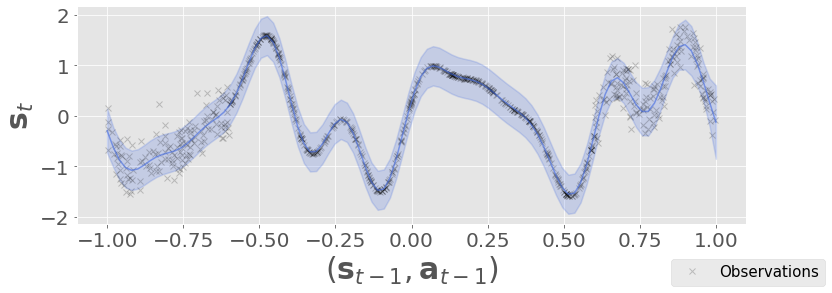

In [36]:
plot_model(m_, y=True, save_name='img/motivation.pdf')

In [37]:
from gpflow import kullback_leiblers, features, settings, transforms
from gpflow.conditionals import conditional, Kuu
from gpflow.decors import params_as_tensors
from gpflow.models.model import GPModel
from gpflow.params import DataHolder, Minibatch, Parameter
from gpflow.mean_functions import Zero
from gpflow.models.model import Model
from gpflow.decors import params_as_tensors, autoflow
from gpflow.quadrature import ndiagquad

float_type = gpflow.settings.float_type

In [38]:
from gpflow.likelihoods import Likelihood, SwitchedLikelihood, Gaussian, Bernoulli

def inv_probit(x):
    jitter = 1e-3  # ensures output is strictly between 0 and 1
    return 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter


class BernoulliGaussian(Likelihood):
    def __init__(self, variance_low=0.005, variance_high=0.3, invlink=inv_probit, **kwargs):
        super().__init__(**kwargs)
        self.invlink = invlink
        self.variance_low = Parameter(
            variance_low, transform=transforms.positive, dtype=settings.float_type)
        self.variance_high = Parameter(
            variance_high, transform=transforms.positive, dtype=settings.float_type)
        self.likelihood_bern = Bernoulli()
#         self.variance_low.trainable = False
#         self.variance_high.trainable = False

    @params_as_tensors
    def predict_mean_and_var_f_high(self, Fmu, Fvar):
        return tf.identity(Fmu), Fvar + self.variance_high

    @params_as_tensors
    def predict_mean_and_var_f_low(self, Fmu, Fvar):
        return tf.identity(Fmu), Fvar + self.variance_low

    @params_as_tensors
    def predict_mean_and_var_a(self, Hmu, Hvar):
        return self.likelihood_bern.predict_mean_and_var(Hmu, Hvar)

    @params_as_tensors
    def predict_mean_a(self, H):
        return inv_probit(H)

In [39]:
class BMNSVGP(Model):

    def __init__(self, X, Y, var_low, var_high, minibatch_size=None):
        """
        - X is a data matrix, size N x D
        - Y is a data matrix, size N x P
        """
        Model.__init__(self, name="BMNSVGP")
        if minibatch_size is not None:
            self.X = Minibatch(X, batch_size=minibatch_size, seed=0)
            self.Y = Minibatch(Y, batch_size=minibatch_size, seed=0)
        else:
            self.X = Dataholder(X)
            self.Y = Dataholder(Y)

        self.num_data = X.shape[0]
        self.whiten = True
#         num_inducing = len(self.feature)

        # init mean functions
        self.mean_function_h = Zero(output_dim=1)
        self.mean_function_f_low = Zero(output_dim=Y.shape[1])
        self.mean_function_f_high = Zero(output_dim=Y.shape[1])

        # init kernels
        self.kern_h = gpflow.kernels.RBF(input_dim=X.shape[1])
        self.kern_f_low = gpflow.kernels.RBF(input_dim=X.shape[1])
        self.kern_f_high = gpflow.kernels.RBF(input_dim=X.shape[1])

        # init sparse features
        feat = None
        M = 50
#         idx = np.random.choice(range(X.shape[0]), size=M, replace=False).reshape(-1, 1)
#         X_ = tf.layers.flatten(X)
        idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
        Z = X[idx, ...].reshape(-1, 1)
        self.feature_h = features.inducingpoint_wrapper(feat, Z)
        self.feature_h.trainable = False
        self.feature_f_low = features.inducingpoint_wrapper(feat, Z)
        self.feature_f_low.trainable = False
        self.feature_f_high = features.inducingpoint_wrapper(feat, Z)
        self.feature_f_high.trainable = False

        # init likelihood
        self.likelihood = BernoulliGaussian(variance_low=var_low, variance_high=var_high)

        # init variational parameters
        # TODO: auto select number of inducing points
        q_mu_h = np.zeros((50, 1)) + rnd.randn(50, 1)
#         q_mu_h = np.zeros((50, 1)) + rnd.randn(50, 1) * 10
        q_sqrt_h = np.array([10*np.eye(50, dtype=settings.float_type) for _ in range(1)])
#         q_mu_h = np.zeros((50, 1))
#         q_mu_h[Z>0] += -1
#         q_mu_h[Z<0] += 100
        self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=50, num_latent=1, q_mu=q_mu_h, q_sqrt=q_sqrt_h)
#         self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=50, num_latent=1)
        self.q_mu_f_low, self.q_sqrt_f_low = self._init_variational_parameters(num_inducing=50, num_latent=self.Y.shape[1])
        self.q_mu_f_high, self.q_sqrt_f_high = self._init_variational_parameters(num_inducing=50, num_latent=self.Y.shape[1])

    def _init_variational_parameters(self, num_inducing, num_latent, q_mu=None, q_sqrt=None, q_diag=None):
        q_mu = np.zeros((num_inducing, num_latent)) if q_mu is None else q_mu
#         q_mu = q_mu + rnd.randn(q_mu.shape[0], q_mu.shape[1])
        q_mu = Parameter(q_mu, dtype=settings.float_type)  # M x P

        if q_sqrt is None:
            if q_diag:
#                 q_sqrt = q_sqrt + rnd.randn(q_sqrt.shape[0], q_sqrt.shape[1])
                q_sqrt = Parameter(np.ones((num_inducing, num_latent), dtype=settings.float_type),
                                        transform=transforms.positive)  # M x P
            else:
                q_sqrt = np.array([np.eye(num_inducing, dtype=settings.float_type) for _ in range(num_latent)])
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # P x M x M
        else:
            if q_diag:
                assert q_sqrt.ndim == 2
                num_latent = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.positive)  # M x L/P
            else:
                assert q_sqrt.ndim == 3
                num_latent = q_sqrt.shape[0]
                num_inducing = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # L/P x M x M
        return q_mu, q_sqrt

    @params_as_tensors
    def build_prior_KL(self, feature, kern, q_mu, q_sqrt):
        if self.whiten:
            K = None
        else:
            K = Kuu(feature, kern, jitter=settings.numerics.jitter_level)  # (P x) x M x M

        return kullback_leiblers.gauss_kl(q_mu, q_sqrt, K)

    def _sample_e_h(self, dist_h, f_low, f_high, num_samples=1000):
        h = tf.reshape(dist_h.sample(num_samples), [-1, num_samples])
        p_a_0 = 1 - inv_probit(h)

        dist_y_low = tf.distributions.Normal(loc=f_low, scale=self.likelihood.variance_low)
        dist_y_high = tf.distributions.Normal(loc=f_high, scale=self.likelihood.variance_high)
        p_y_low = dist_y_low.prob(self.Y)
        p_y_high = dist_y_high.prob(self.Y)
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y_low * p_a_0 + p_y_high * (1 - p_a_0)), axis=1)

    def _sample_e_f(self, dist_f_low, dist_f_high, h, num_samples=1000):
        p_a_0 = 1 - inv_probit(h)

        f_low = tf.reshape(dist_f_low.sample(num_samples), [-1, num_samples])
        f_high = tf.reshape(dist_f_high.sample(num_samples), [-1, num_samples])

        dist_y_low = tf.distributions.Normal(loc=f_low, scale=self.likelihood.variance_low)
        dist_y_high = tf.distributions.Normal(loc=f_high, scale=self.likelihood.variance_high)
        p_y_low = dist_y_low.prob(self.Y)
        p_y_high = dist_y_high.prob(self.Y)
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y_low * p_a_0 + p_y_high * (1 - p_a_0)), axis=1)

    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        # Get prior KL.
        KL_h = self.build_prior_KL(self.feature_h, self.kern_h, self.q_mu_h, self.q_sqrt_h)
        KL_f_low = self.build_prior_KL(self.feature_f_low, self.kern_f_low, self.q_mu_f_low, self.q_sqrt_f_low)
        KL_f_high = self.build_prior_KL(self.feature_f_high, self.kern_f_high, self.q_mu_f_high, self.q_sqrt_f_high)

        # Lets get conditional p(h_n | U_h, x_n) for all N
        h_mean, h_var = self._build_predict_h(self.X, full_cov=False, full_output_cov=False)

        # Lets get conditionals p(f_n_1 | U_f_1, x_n) and p(f_n_2 | U_f_2, x_n) for all N
        f_mean_low, f_var_low = self._build_predict_f_low(self.X, full_cov=False, full_output_cov=False)
        f_mean_high, f_var_high = self._build_predict_f_high(self.X, full_cov=False, full_output_cov=False)

        dist_f_low = tf.distributions.Normal(loc=f_mean_low, scale=f_var_low)
        dist_f_high = tf.distributions.Normal(loc=f_mean_high, scale=f_var_high)
        dist_h = tf.distributions.Normal(loc=h_mean, scale=h_var)

        f_high = f_mean_high
        f_low = f_mean_low
        var_exp_h = self._sample_e_h(dist_h, f_low, f_high, num_samples=1)
        var_exp_f = self._sample_e_f(dist_f_low, dist_f_high, h_mean, num_samples=1)
        var_exp = var_exp_f + var_exp_h

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)
        return tf.reduce_sum(var_exp) * scale - KL_f_low - KL_f_high - KL_h

    @params_as_tensors
    def _build_predict_h(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_h, self.kern_h, self.q_mu_h, q_sqrt=self.q_sqrt_h, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_h(Xnew), var

    @params_as_tensors
    def _build_predict_f_low(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_f_low, self.kern_f_low, self.q_mu_f_low, q_sqrt=self.q_sqrt_f_low, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_f_low(Xnew), var

    @params_as_tensors
    def _build_predict_f_high(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_f_high, self.kern_f_high, self.q_mu_f_high, q_sqrt=self.q_sqrt_f_high, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_f_high(Xnew), var

    @autoflow((settings.float_type, [None, None]))
    def predict_a(self, Xnew):
        h_mean, h_var = self._build_predict_h(Xnew)
        return self.likelihood.predict_mean_and_var_a(h_mean, h_var)

    @autoflow((settings.float_type, [None, None]))
    def predict_h(self, Xnew):
        return self._build_predict_h(Xnew)

    @autoflow((settings.float_type, [None, None]))
    def predict_f_low(self, Xnew):
        pred_f_mean, pred_f_var = self._build_predict_f_low(Xnew)
        return self.likelihood.predict_mean_and_var_f_low(pred_f_mean, pred_f_var)

    @autoflow((settings.float_type, [None, None]))
    def predict_f_high(self, Xnew):
        pred_f_mean, pred_f_var = self._build_predict_f_high(Xnew)
        return self.likelihood.predict_mean_and_var_f_high(pred_f_mean, pred_f_var)

#     @autoflow((settings.float_type, [None, None]))
    def predict_y(self, Xnew):
        # TODO: how to incorporate unc in assignment???
        pred_f_mean_low, pred_f_var_low = self.predict_f_low(Xnew)
        pred_f_mean_high, pred_f_var_high = self.predict_f_high(Xnew)
        pred_a_mean, pred_a_var = self.predict_a(Xnew)
        f_mean = pred_f_mean_low * (1-pred_a_mean) + pred_f_mean_high * pred_a_mean
        f_var = pred_f_var_low * (1-pred_a_mean) + pred_f_var_high * pred_a_mean
        return f_mean, f_var

In [40]:
gpflow.reset_default_graph_and_session()

with gpflow.defer_build():
    m = BMNSVGP(X, Y, var_low=0.005, var_high=0.3, minibatch_size=100)
#     m = BMNSVGP(X, Y, var_low=0.001, var_high=0.7, minibatch_size=100)
m.compile()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


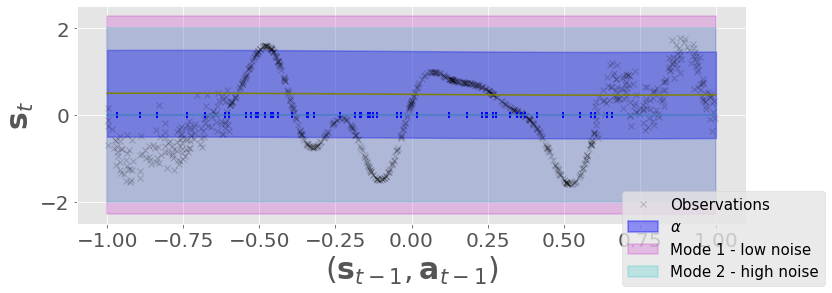

In [41]:
plot_model(m, m1=True, m2=True, a=True)
# plot_model(m, m1=True, m2=True, a=False)

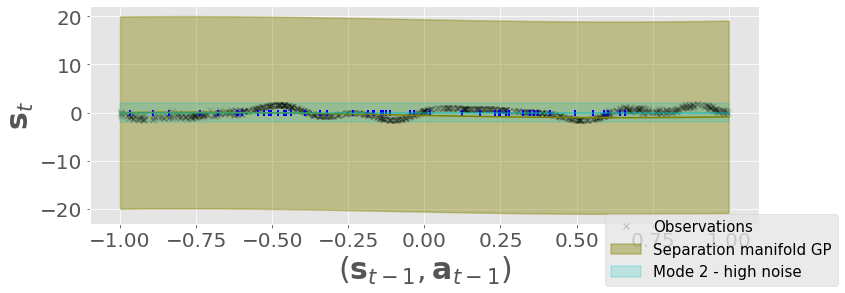

In [42]:
plot_model(m, m1=True, m2=True, h=True)
# plot_model(m, m1=True, m2=True, a=False)

In [43]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BMNSVGP/feature_f_high/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/feature_f_low/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/feature_h/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/kern_f_high/lengthscales,Parameter,None,+ve,True,(),True,1.0
BMNSVGP/kern_f_high/variance,Parameter,None,+ve,True,(),True,1.0
BMNSVGP/kern_f_low/lengthscales,Parameter,None,+ve,True,(),True,1.0
BMNSVGP/kern_f_low/variance,Parameter,None,+ve,True,(),True,1.0
BMNSVGP/kern_h/lengthscales,Parameter,None,+ve,True,(),True,1.0
BMNSVGP/kern_h/variance,Parameter,None,+ve,True,(),True,1.0
BMNSVGP/likelihood/variance_high,Parameter,None,+ve,True,(),True,0.3


In [44]:
logger = run_adam(m, maxiter=gpflow.test_util.notebook_niter(15000))

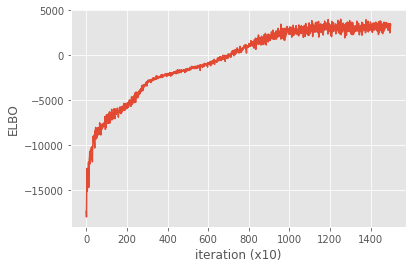

In [47]:
plot_loss(logger)

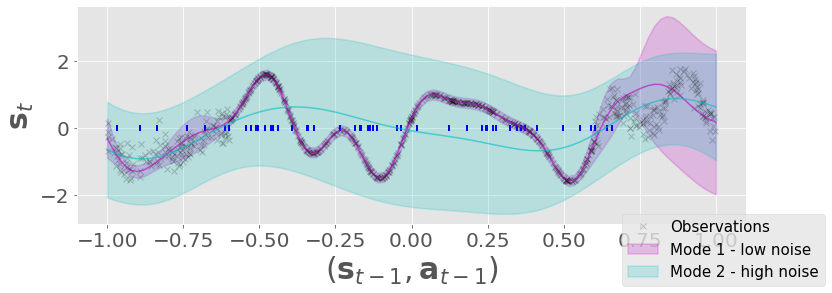

In [55]:
# plot_model(m, m1=True, m2=True, h=True, a=False)
plot_model(m, m1=True, m2=True, a=False, save_name='img/joint_sep.pdf')

In [56]:
def plot_a(m, a, save_name=False):
    fig = plt.figure(figsize=(12, 4))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations

    plt.plot(XX, a, '-', color='k', label='True $\\alpha$', alpha=0.9)
    plt.plot(m.feature_f_low.Z.value, np.zeros(m.feature_f_low.Z.value.shape), 'k|', mew=2)
    plt.plot(m.feature_f_high.Z.value, np.zeros(m.feature_f_high.Z.value.shape), 'b|', mew=2)
    a_mu, a_var = m.predict_a(pX) # Predict alpha values at test locations
#     plt.plot(pX, a_mu, color='olive', lw=1.5)
#     plt.fill_between(pX[:, 0], (a_mu-2*a_var**0.5)[:, 0], (a_mu+2*a_var**0.5)[:, 0], color='blue', alpha=0.4, lw=1.5, label='$\\alpha$')
    plt.plot(pX, -a_mu+1., color='olive', lw=1.5)
    plt.fill_between(pX[:, 0], -(a_mu-2*a_var**0.5)[:, 0]+1., -(a_mu+2*a_var**0.5)[:, 0]+1., color='blue', alpha=0.4, lw=1.5, label='Learnt $\\alpha$')
    fig.legend(loc='lower right', fontsize=15)
    plt.xlabel('$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$', fontsize=30)
    plt.ylabel('$\\alpha$', fontsize=30)
#     plt.xlim(-1.0, 1.2)
    plt.tick_params(labelsize=20)
    if save_name is not False:
        plt.savefig(save_name, transparent=True, bbox_inches='tight')

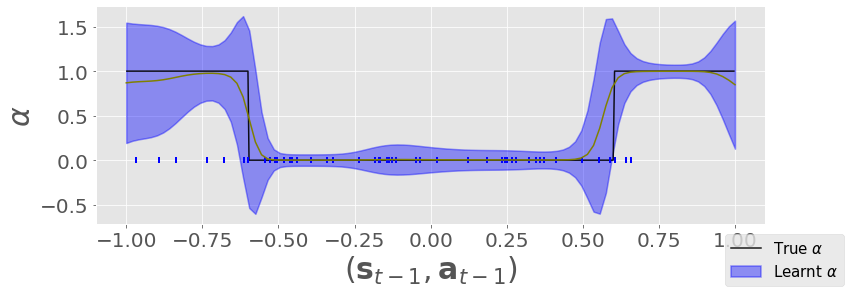

In [57]:
# plot_model(m, a=True)
XX = np.sort(X, axis=0)
a = np.zeros([N, 1])
a[XX<-0.6] = 1
a[XX>0.6] = 1
# plot_a(m, a, save_name='img/learnt_alpha.pdf')
plot_a(m, a)
# plt.savefig("img/joint_all.pdf", transparent=True, bbox_inches='tight')

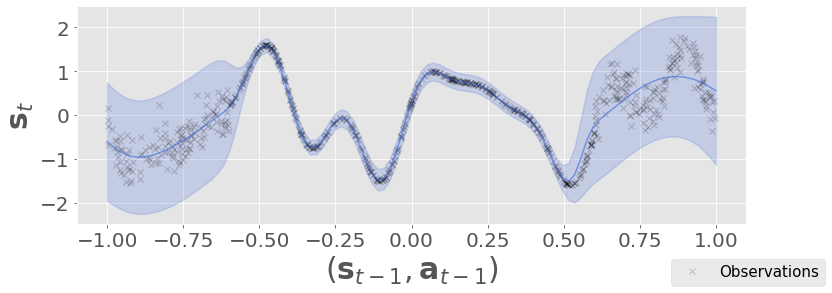

In [58]:
plot_model(m, y=True)
# plt.savefig("img/joint_combined.pdf", transparent=True, bbox_inches='tight')

In [52]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BMNSVGP/feature_f_high/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/feature_f_low/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/feature_h/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/kern_f_high/lengthscales,Parameter,None,+ve,True,(),True,0.11078321707218727
BMNSVGP/kern_f_high/variance,Parameter,None,+ve,True,(),True,1.141797109956382
BMNSVGP/kern_f_low/lengthscales,Parameter,None,+ve,True,(),True,0.2540420023524837
BMNSVGP/kern_f_low/variance,Parameter,None,+ve,True,(),True,0.9538341115061906
BMNSVGP/kern_h/lengthscales,Parameter,None,+ve,True,(),True,0.15067927896759725
BMNSVGP/kern_h/variance,Parameter,None,+ve,True,(),True,1.5491100582410935
BMNSVGP/likelihood/variance_high,Parameter,None,+ve,True,(),True,0.005028360975248619


In [53]:
# session = gpflow.get_default_session()
# pa = session.run(m.p_a_0_tensor)
# # print(pa)
# plt.scatter(m.X, pa)

In [26]:
# saver = gpflow.saver.Saver()
# saver.save('saved_models/joint_inference', m)